In [25]:
from train import Trainer, visualize_predictions
from model import Model
from torch.utils.data import  DataLoader
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from utils import TimeSeriesDataset
import numpy as np
import torch

## Training Parameters

In [26]:
DATA_PATH = './data/*.csv'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-3
MODEL_SAVE_PATH = './model_checkpoint.pth'
LOOKBACK_STEPS = 20
FORECAST_STEPS = 5


## Preprocess Data

In [27]:
csv_files = sorted(glob.glob(DATA_PATH))
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)
data = df.iloc[:, 1:].copy()
data = data.replace(-9999, np.nan).ffill().dropna()

for col in data.columns:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3 * std) & (data[col] <= mean + 3 * std)]

data = data.values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
# pd.DataFrame(data_normalized).hist(bins=50, figsize=(20, 15)) # uncomment to visualize feature distributions

## Create Dataset and Initialize Model

Change model configs here

In [29]:
train_size = int(0.8 * len(data_normalized))
train_data = TimeSeriesDataset(data_normalized[:train_size], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
test_data = TimeSeriesDataset(data_normalized[train_size:], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train data shape: {len(train_data)}")
print(f"Test data shape: {len(test_data)}")

model = Model(
    num_variates=data_normalized.shape[1],
    lookback_steps=LOOKBACK_STEPS,
    forecast_steps=FORECAST_STEPS,

    d_model=128,  # Embedding dimension (same for both streams)

    # Stream 1: iTransformer
    n_heads_s1=4,
    n_layers_s1=2,
    d_ff_s1=128,
    dropout_s1=0.3,

    # Stream 2: Powerformer
    patch_len=2,
    stride=8,
    n_heads_s2=4,
    n_layers_s2=2,
    d_ff_s2=128,
    dropout_s2=0.3,
    attn_decay_scale=0.25,

    # Fusion
    n_heads_fusion=2,
)


Train data shape: 8864
Test data shape: 2199


## Train Model

In [30]:
# Initialize trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

Model initialized on cpu
Total parameters: 584,047
Trainable parameters: 584,047


Change training configs here 

In [31]:
history = trainer.train(
    num_epochs=1,                           # Number of training epochs
    use_scheduler=True,                      # Enable ReduceLROnPlateau scheduler
    scheduler_factor=0.5,                    # LR reduction factor (new_lr = lr * factor)
    scheduler_patience=1,                    # Epochs to wait before reducing LR
    save_dir='./experiments',                # Directory to save models and metrics
    save_metrics=True,                       # Save training metrics as JSON
    experiment_name='test',         # Name for this experiment (used in filenames)
    results_file='all_experiments.json',     # Shared file for all experiments (None for individual files)
    append_results=True,                     # Append to results_file (False to overwrite)
    plot_predictions=True,                   # Generate prediction plots at end of training
    num_plot_samples=5,                      # Number of random samples to visualize
    num_plot_variates=4                      # Number of variates to show per sample
)



Starting training: 1 epochs
Scheduler: Enabled




Epoch 1/1 Summary:
  Train Loss: 0.132985
  Val Loss:   0.124189
  Val MAE:    0.155958
  LR:         1.00e-03


Training completed!

Model saved: ./experiments\model_test_20251203_194524.pth
Results saved: ./experiments\all_experiments.json

Final Results:
  Train Loss (MSE): 0.132985
  Test Loss (MSE):  0.124189
  Test MAE:         0.155958
  Best Test Loss:   0.124189 (epoch 1)
  Best Test MAE:    0.155958 (epoch 1)

Generating prediction plots...
Prediction plot saved: ./experiments\predictions_20251203_194524.png


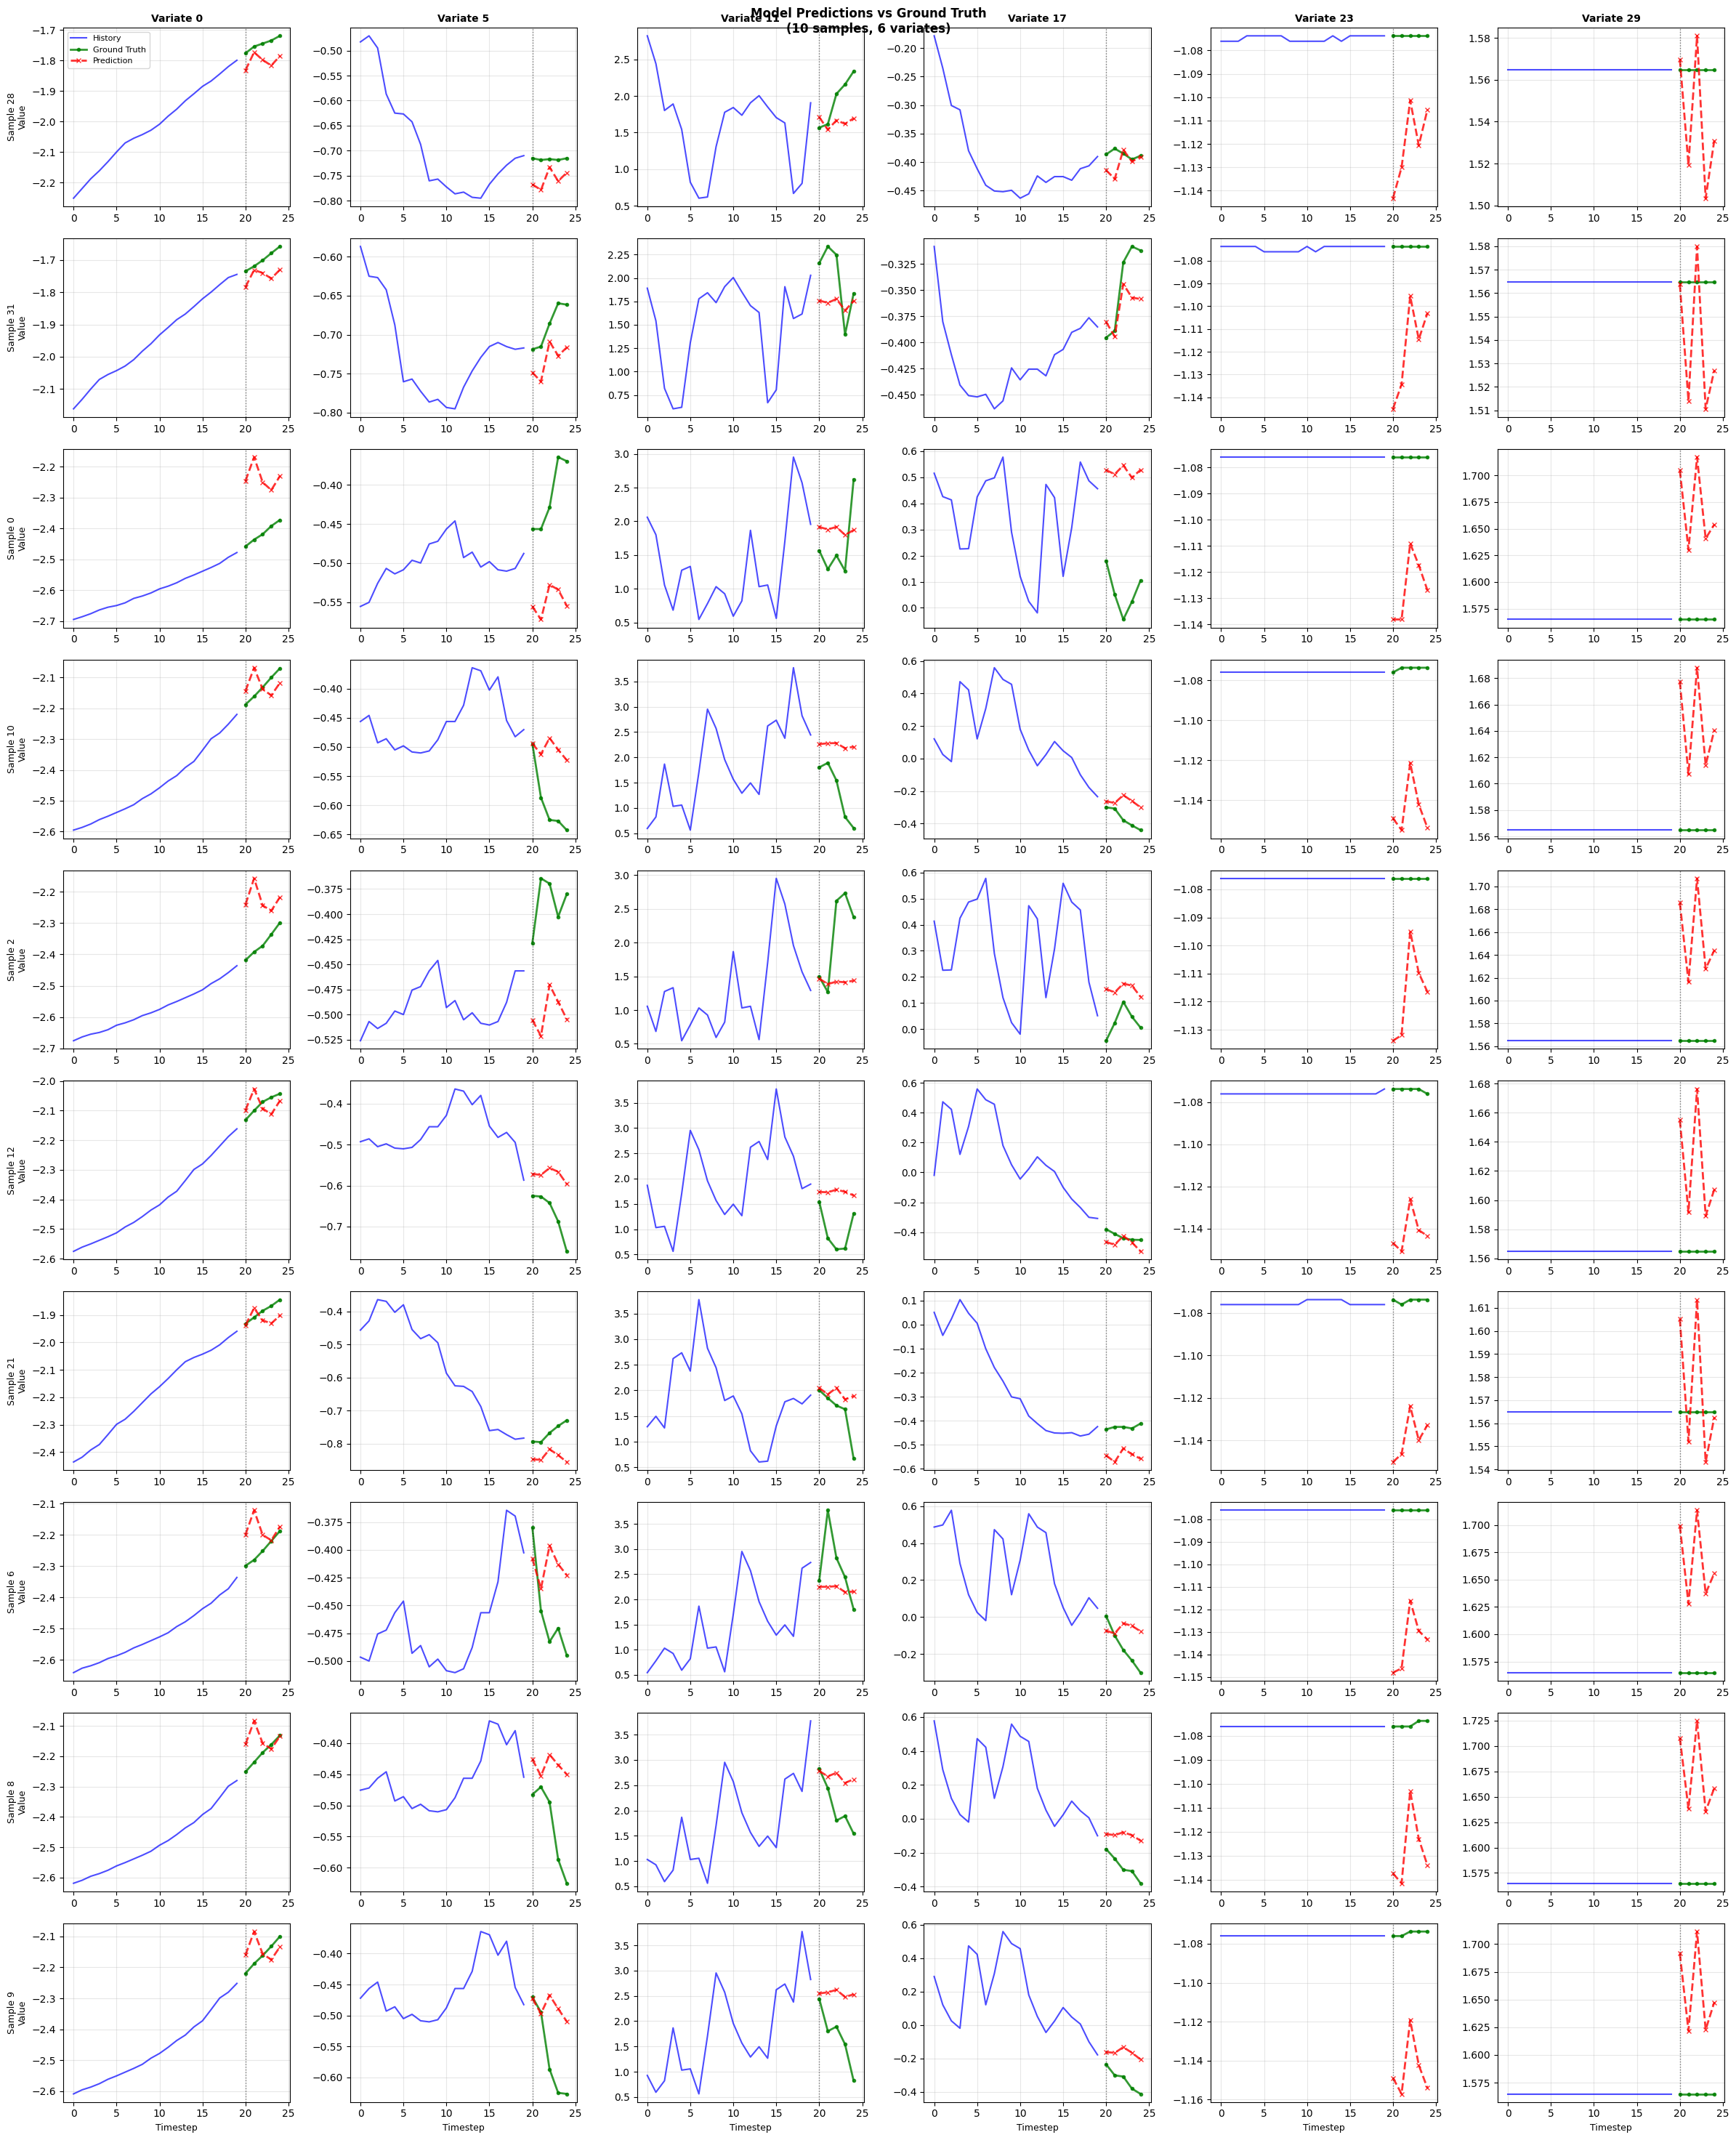

In [34]:
visualize_predictions(
    model=model,
    data_loader=test_loader,
    device='cpu',
    num_samples=10,
    num_variates=6,
    save_path=None
)